## Getting number of texts in total

In [27]:
import json
import os

def count_texts_in_jsonl_files(folder_path):
    total_texts = 0

    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jsonl'):
            file_path = os.path.join(folder_path, file_name)

            # Open and read the JSONL file
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    try:
                        # Attempt to load each line as a JSON object
                        json.loads(line)
                        total_texts += 1
                    except json.JSONDecodeError:
                        # Skip the line if it's not a valid JSON object
                        continue

    return total_texts

# Specify the path to the folder containing your JSONL files
input_folder_path = '../../LLM_Bias/arxiv_data/'

# Count the number of texts
num_texts = count_texts_in_jsonl_files(input_folder_path)
print(f"Total number of texts in JSONL files: {num_texts}")


Total number of texts in JSONL files: 1558306


### Checking Range of Timestamps for the arXiv Search

In [2]:
import json
import os
from datetime import datetime

def get_timestamp_range(folder_path):
    timestamps = []

    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jsonl'):
            file_path = os.path.join(folder_path, file_name)

            # Open and read the JSONL file
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    try:
                        # Load each line as a JSON object
                        data = json.loads(line)
                        meta = data.get('meta', {})
                        timestamp_str = meta.get('timestamp')
                        if timestamp_str:
                            # Parse the timestamp string into a datetime object
                            timestamp = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S')
                            timestamps.append(timestamp)
                    except (json.JSONDecodeError, ValueError) as e:
                        print(f"Error processing line: {e}")
                        continue

    # Sort the timestamps to find the first and last dates
    if timestamps:
        timestamps.sort()
        first_date = timestamps[0]
        last_date = timestamps[-1]
        return first_date, last_date
    else:
        return None, None

# Specify the path to the folder containing your JSONL files
input_folder_path = '../../LLM_Bias/arxiv_data/'

# Retrieve the first and last timestamps
first_timestamp, last_timestamp = get_timestamp_range(input_folder_path)

if first_timestamp and last_timestamp:
    print(f"First timestamp: {first_timestamp}")
    print(f"Last timestamp: {last_timestamp}")
else:
    print("No timestamps found in the data.")


First timestamp: 1991-08-21 03:40:51
Last timestamp: 2023-03-07 02:32:27


### Visualizing articles over time

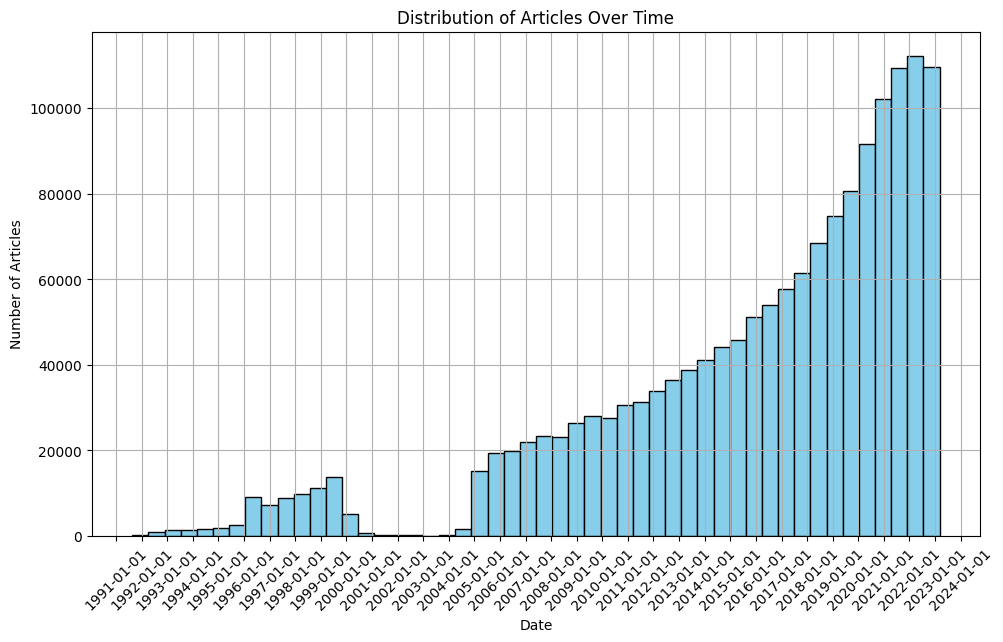

In [1]:
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates

def collect_timestamps(folder_path):
    timestamps = []

    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jsonl'):
            file_path = os.path.join(folder_path, file_name)

            # Open and read the JSONL file
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    try:
                        # Load each line as a JSON object
                        data = json.loads(line)
                        meta = data.get('meta', {})
                        timestamp_str = meta.get('timestamp')
                        if timestamp_str:
                            # Assuming the timestamp format is like '2019-04-30T02:17:30'
                            timestamp = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S')
                            timestamps.append(timestamp)
                    except (json.JSONDecodeError, ValueError) as e:
                        print(f"Error processing line: {e}")
                        continue

    return timestamps

def plot_timestamps_distribution(timestamps):
    dates = matplotlib.dates.date2num(timestamps)

    plt.figure(figsize=(10, 6))
    plt.hist(dates, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Articles Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(matplotlib.dates.YearLocator())
    plt.show()

# Specify the path to the folder containing your JSONL files
input_folder_path = '../../LLM_Bias/arxiv_data/'

# Collect all timestamps
timestamps = collect_timestamps(input_folder_path)

# Plot the distribution if there are any timestamps
if timestamps:
    plot_timestamps_distribution(timestamps)
else:
    print("No timestamps found in the data.")

## Regex Search

### Defining Regex 

In [3]:
import re 

AUROC_REGEXES = [
    r"\bAUC?\-?\(?ROC\)?\b", 
    r"\bAUC\b", 
    r"\barea under the curve\b", 
    r"\bROC\b", 
    r"\breceiver operating characteristic\b",
    r"sensitivity \s*(vs\.?|v\.?|versus|against|compared with) \s*(1\s?-\s?specificity|specificity)", 
    r"(true positive rate|TPR) \s*(vs\.?|v\.?|versus|against|compared with) \s*(false positive rate|FPR)"
]

# Note: For longer phrases or those with variable parts, word boundaries are applied where clear, unambiguous matches are possible.
AUPRC_REGEXES = [
    r"\bAUC?\-?\(?PRC\)?\b", 
    r"\bprecision[\s-]?recall\b", 
    r"\bAPR\b", 
    r"\baverage[\s-]?precision\b", 
    r"\bPRC\b"
]

# Here, each term is enclosed with word boundaries to ensure they are matched as whole words only.

COMBINED_AUROC_REGEX = r"(?i)(" + '|'.join(AUROC_REGEXES) + r")"
compiled_auroc_regex = re.compile(COMBINED_AUROC_REGEX)

COMBINED_AUPRC_REGEX = r"(?i)(" + '|'.join(AUPRC_REGEXES) + r")"
compiled_auprc_regex = re.compile(COMBINED_AUPRC_REGEX)


### Getting texts with the regex

In [1]:
# Importing necessary functions and keyword lists
import sys
sys.path.append('src')  # Ensure the 'src' folder is in the Python path
from arxiv_search_regex import jsonl_folder_filtering

In [4]:
# Inputs
input_folder_path = 'arxiv_data'
output_folder_path = 'data'
metadata_keys = ['timestamp', 'yymm', 'arxiv_id', 'language', 'url']

# Call the function
df_output = jsonl_folder_filtering(
    input_folder_path=input_folder_path,
    auroc_regex=compiled_auroc_regex,
    auprc_regex=compiled_auprc_regex,
    metadata_keys=metadata_keys,
    output_folder_path=output_folder_path,
    remove_latex=True,
    save_file=True,
    filename="filtered_data_v2.csv",  # Changed to .csv for clarity
    total_texts_filename="total_texts_v2.txt"
)

## Visualizing number of citations over time

'figures/papers_over_time.png'

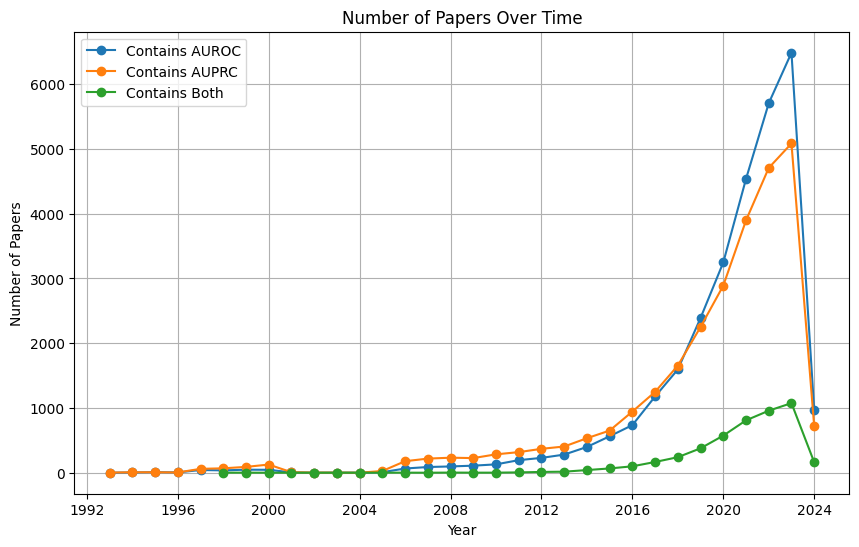

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
# Convert timestamp to datetime
df_output['timestamp'] = pd.to_datetime(df_output['timestamp'])

# Resample data by year
df_yearly = df_output.resample('Y', on='timestamp').agg({'contains_auroc': 'sum', 'contains_auprc': 'sum'})

# Calculate papers that contain both
df_yearly['contains_both'] = df_output[(df_output['contains_auroc'] == True) & (df_output['contains_auprc'] == True)].resample('Y', on='timestamp').size()

# File path for the figure
figures_dir = "figures"
figure_path = os.path.join(figures_dir, 'papers_over_time.png')

# Save the figure
plt.figure(figsize=(10, 6))
plt.plot(df_yearly.index, df_yearly['contains_auroc'], label='Contains AUROC', marker='o')
plt.plot(df_yearly.index, df_yearly['contains_auprc'], label='Contains AUPRC', marker='o')
plt.plot(df_yearly.index, df_yearly['contains_both'], label='Contains Both', marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.title('Number of Papers Over Time')
plt.legend()
plt.grid(True)
plt.savefig(figure_path)

figure_path

### Filtering only data that contains AUROC and AUPRC keywords

In [7]:
df_filtered_v2 = df_output[(df_output['contains_auroc'] == True) & (df_output['contains_auprc'] == True)]

#### Loading old ones (found with old search, to see if we capture the same)

In [8]:
import pandas as pd
from tqdm import tqdm
import re

# Load data
df_output = pd.read_csv('data/arxiv_filter_auc.csv')

# Filter rows
df_filtered = df_output[(df_output['contains_auroc'] == True) & (df_output['contains_auprc'] == True)]

#### Searching in old ones

In [9]:
# Check presence of df_output 'arxiv_id's in df_output_v2
matching_ids = df_filtered_v2['arxiv_id'].isin(df_filtered['arxiv_id'])

# Count the number of True values in the Boolean array, which represent matches
num_matches = matching_ids.sum()

print(f"Number of matching 'arxiv_id' rows: {num_matches}")

Number of matching 'arxiv_id' rows: 3775


### Importing function to extract context window

In [12]:
# Importing necessary functions and keyword lists
import sys
sys.path.append('src')  # Ensure the 'src' folder is in the Python path

from claim_search_v3 import extract_context_windows_df

compiled_regexes = [compiled_auroc_regex, compiled_auprc_regex]

### Extracting

In [14]:
df_with_context_windows = extract_context_windows_df(df_filtered_v2, 'text', [compiled_auroc_regex, compiled_auprc_regex], window_size=500)

### Saving

In [21]:
df_with_context_windows.to_csv('data/filtered_data_with_context_windows_v3.csv', index=False)

### Loading again

In [2]:
import pandas as pd
df_with_context_windows = pd.read_csv('data/filtered_data_with_context_windows_v3.csv')

In [3]:
df_with_context_windows['context_window'] = df_with_context_windows['text']

## Searching for specific claims that AUPRC is suprior to AUROC with GPT 3.5/4

### Defining prompt and importing function

In [5]:
SYSTEM_PROMPT = """
You are an expert in machine learning and scientific literature review.
For each chunk of a published paper (which may have typos, misspellings, and odd characters as a result of conversion from PDF), return a JSON object that states whether or not the paper makes any claim that the area under the precision recall curve (AUPRC) is superior or inferior as a general performance metric to the area under the receiver operating characteristic (AUROC) in an ML setting, in particular for imbalanced classification problems. A paper claiming that a model performs better under AUPRC vs. AUROC is *not* an example of this; instead a paper claiming that AUPRC should be used instead of AUROC in cases of class imbalance is an example of this metric commentary. Respond with format {"claims": [{"claim": DESCRIPTION OF CLAIM, "evidence_quote": SUBSTRING FROM INPUT STATING CLAIM}, ...]}. If the paper makes no claims, leave the "claims" key in the JSON object empty. If the claim made is that the AUPRC is superior to the AUROC in the case of class imbalance, use the string "AUPRC is superior to AUROC for imbalanced data" for the description of the claim. For other claims, use any appropriate free-text description.

Examples: 

Input: "AUROC: The horizontal and vertical coordinates of the Receiver Operating Characteristic (ROC) curve are the FPR and TPR, and the curve is obtained by calculating the FPR and TPR under multiple sets of thresholds. The area of the region enclosed by the ROC curve and the horizontal axis is often used to evaluate binary classification tasks, denoted as AUROC. The value of AUROC is within the range of [0, 1], and higher values indicate better performance. AUROC can visualize the generalization performance of the GVAED model and help to select the best alarm threshold In addition, the Equal Error Rate (EER), i.e., the proportion of incorrectly classified frames when TPR and FNR are equal, is also used to measure the performance of anomaly detection models. AP: Due to the highly unbalanced nature of positive and negative samples in GVAED tasks, i.e., the TN is usually larger than the TP, researchers think that the area under the Precision-Recall (PR) curve is more suitable for evaluating GVAED models, denoted as AP. The horizontal coordinates of the PR curve are the Recall (i.e., the TPR in Eq. 4), while the vertical coordinate represents the Precision, defined as Precision = TP TP+FP . A point on the PR curve corresponds to the Precision and Recall values at a certain threshold."
Output: {"claims": [{"claim": "AUPRC is superior to AUROC for imbalanced data", "evidence_quote": "Due to the highly unbalanced nature of positive and negative samples in GVAED tasks, i.e., the TN is usually larger than the TP, researchers think that the area under the Precision-Recall (PR) curve is more suitable for evaluating GVAED models, denoted as AP"}]}

Input: "As seen, it outperforms other approaches except in the cases of TinyImageNet for CIFAR-100. Our approach still has better AUROC, but the detection error and FPR at 95% TPR are slightly larger than ODIN’s. Interestingly, the MD approach is worse than max-softmax in some cases. Such a result has also been reporte"
Output: {"claims": []}

Input: "AUC-ROC measures the class separability at various threshold settings. ROC is the probability curve and AUC represents the degree of measures of separability. It compares true positive rate (sensitivity/recall) versus the false positive rate (1 - specificity). The higher the AUC-ROC, the bigger the distinction between the true positive and false negative. • AUC-PR: It combines the precision and recall, for various threshold values, it compares the positively predicted value (precision) vs the true positive rate (recall). Both precision and recall focus on the positive class (the lesion) and unconcerned about the true negative (not a lesion, which is the majority class). Thus, for class imbalance, PR is more suitable than ROC. The higher the AUC-PR, the better the model performance"
Output: {"claims": [{"claim": "AUPRC is superior to AUROC for imbalanced data", "evidence_quote": "Thus, for class imbalance, PR is more suitable than ROC"}]}

Input: "The AP score has largely superseded the older area under the receiver operating characteristic (ROC) curve in the computer vision community in favor of the AP score’s greater sensitivity for high-performing networks."
Output: {"claims": [{"claim": "AUPRC is more sensitive than AUROC for high performing models", "evidence_quote": "AP score’s greater sensitivity for high-performing networks"}]}
"""


In [ ]:
import sys
sys.path.append('src')  # Adjust this path to ensure it points to the correct directory

from claim_search_v3 import process_all_context_windows

In [6]:
# Set your OpenAI API key and other relevant parameters
model = "gpt-3.5-turbo-1106"
df_2000 = df_with_context_windows.iloc[0:2000] ### Getting first 2000 to test
# Process the DataFrame
first_2000_df = process_all_context_windows(df_2000, model, SYSTEM_PROMPT, openai_api_key, texts_before_pause=1000, pause_duration=0.5)

# Save the updated DataFrame
first_2000_df.to_csv('data/processed_gpt_responses_first_2000.csv', index=False)


Rate limit reached, retrying in 0.5 seconds...
Rate limit reached, retrying in 1.0 seconds...
Rate limit reached, retrying in 0.5 seconds...
Rate limit reached, retrying in 2.0 seconds...
Rate limit reached, retrying in 1.0 seconds...
Rate limit reached, retrying in 0.5 seconds...
Rate limit reached, retrying in 1.0 seconds...
Rate limit reached, retrying in 2.0 seconds...
Rate limit reached, retrying in 4.0 seconds...
Rate limit reached, retrying in 4.0 seconds...
Rate limit reached, retrying in 0.5 seconds...
Rate limit reached, retrying in 0.5 seconds...
Rate limit reached, retrying in 1.0 seconds...
Rate limit reached, retrying in 1.0 seconds...
Rate limit reached, retrying in 0.5 seconds...
Rate limit reached, retrying in 1.0 seconds...
Rate limit reached, retrying in 2.0 seconds...
Rate limit reached, retrying in 8.0 seconds...
Rate limit reached, retrying in 2.0 seconds...
Rate limit reached, retrying in 0.5 seconds...
Rate limit reached, retrying in 8.0 seconds...
Rate limit re

In [7]:
## Old test
print(updated_df['gpt_response'])

0                                        {"claims": []}
1     ```json\n{"claims": [{"claim": "AUPRC is super...
2     {"claims": [{"claim": "AUPRC is superior to AU...
3     {"claims": [{"claim": "AUPRC is superior to AU...
4     {"claims": [{"claim": "AUPRC is superior to AU...
                            ...                        
95                                       {"claims": []}
96                                       {"claims": []}
97    {"claims": [{"claim": "AUPRC is superior to AU...
98                                       {"claims": []}
99                                       {"claims": []}
Name: gpt_response, Length: 100, dtype: object
